In [1]:
import os
import sys
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from pandarallel import pandarallel
import matplotlib.pyplot as plt
sys.path.append('./')
from utils import normalize_image, get_sequences, plot_image, plot_images

In [23]:
root_dir = '/data/jupiter/li.yu/data'
# root_dir = '/data/jupiter/datasets/'
# root_dir = '/data2/jupiter/datasets/'
dataset = 'halohitchhiker_for_dust_analysis'
# dataset = 'halo_rgb_stereo_train_v10_0'
# dataset = 'dust_datasets/halo_buildup_medium_dust_with_human_lo_gilroy_july29'
# dataset = 'productivity_datasets/productivity_set_all_042524_v0.3'
# dataset = 'humans/on_path_aft/on_path_aft_humans_day_2024_rev2_v16'
csv = os.path.join(root_dir, dataset, 'annotations.csv')
# csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
# csv = os.path.join(root_dir, dataset, 'master_annotations_more_drops_cleaned_20240611_rev1_lying_down_sitting_n_stop_events_n_night_dust_rev2_no_drops_w_label_counts.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
# converters = {}
df = pd.read_csv(csv, converters=converters)
df.shape

(200000, 175)

In [13]:
categorical_labels_map = {'objects_pixel_count': {'Utility pole', 'Immovable Objects', 'Buildings', 'Animals', 'Tile-Inlet'}, 
                          'humans_pixel_count': {'Humans'}, 'tractors_or_vehicles_pixel_count': {'Tractors or Vehicles'}, 
                          'dust_pixel_count': {'Heavy Dust'}, 'birds_pixel_count': {'Birds'}, 'airborne_debris_pixel_count': {'Airborne Debris'},
                          'unharvested_field_pixel_count': {'Unharvested Field'}, 'trees_pixel_count': {'Trees'}}
for key in categorical_labels_map:
    print(key, key in df)

objects_pixel_count False
humans_pixel_count False
tractors_or_vehicles_pixel_count False
dust_pixel_count False
birds_pixel_count False
airborne_debris_pixel_count False
unharvested_field_pixel_count False
trees_pixel_count False


## Show image

In [3]:
len(df.unique_id.unique()), len(df.id.unique()), df.rectified_stereo_output_height.unique(), df.rectified_stereo_output_width.unique()

(18776, 12948, array([512]), array([768, 512]))

In [51]:
pred_dir = f'/data/jupiter/li.yu/exps/driveable_terrain_model/v100_11cls_nodrop_dustasdust_0724/{dataset}'
# load seg prediction
pred_df = pd.read_csv(os.path.join(pred_dir, 'output.csv'))
print(pred_df.shape)
# df = df.merge(pred_df.drop(columns=["id", "camera_location"]), on='unique_id')
pred_df['id'] = pred_df['unique_id']
df = df.merge(pred_df.drop(columns=["unique_id", "camera_location"]), on='id')
print(df.shape)

# # load dust prediction
# pred_df = pd.read_csv(os.path.join(pred_dir, 'dust_ratio.csv'))
# print(pred_df.shape)
# df = df.merge(pred_df.drop(columns=["id"]), on='unique_id')
# print(df.shape)

(200000, 24)
(200000, 197)


In [55]:
# df2 = df[df.result_state == 'false_positive']
df2 = df[(df['n_pred_dust-debris_pixels'] > 0.1) & (df.operation_time == 'daytime')]
# df2 = df[df['n_pred_dust-debris_pixels'] > 0.1]
# df2 = df[(df.operation_time == 'dawn_dusk') & (df.collected_on > '2024-01-01')]
# df2 = df[(df.camera_location == 'T13') & (df.camera_location_right == 'T15') & (df.collected_on.str.startswith('2024-07-30'))]
# df2 = df[df.id == '653465e64db7d79afd0cd61d']
# df2 = df[df.bag_name == 'loamy_799_0__10_21_2023-20_52_37']
df2.shape

(1324, 197)

65384c5615f15fe2e8dd248c T11 2023-10-12T22:46:20.357000 0.10927734375


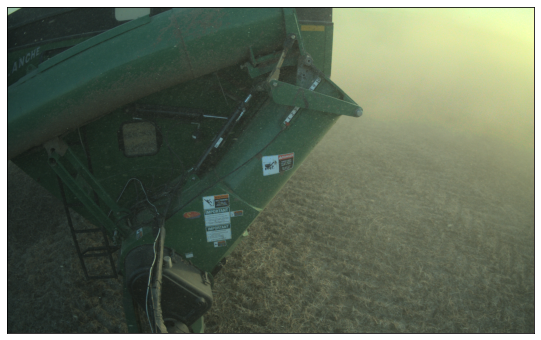

6557f6ca347b47ceff311188 I04 2023-11-04T19:56:34.150000 0.12578125


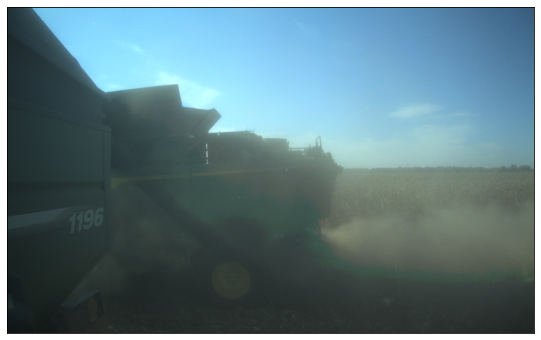

In [58]:
sub_df = df2.sample(2)
show_image, show_label = False, False
show_debayered_rgb, show_raw_label = True, False
show_pred_result = False

for i, row in sub_df.iterrows():
    # print(row.unique_id, row.gt_dust_ratio, row.total_averaged_dust_conf)
    # print(row.unique_id, row.result_state)
    # print(row.id, row.camera_location, row.id_right, row.collected_on)
    print(row.id, row.camera_location, row.collected_on, row['n_pred_dust-debris_pixels'])
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, hdr_mode=row.hdr_mode, return_8_bit=True)
        plot_image(img_norm)

    if show_debayered_rgb:
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)
        # image = imageio.imread(f'{root_dir}/{dataset}/images/{row.id_right}/artifact_debayeredrgb_0_{row.id_right}.png')
        # plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels, counts = np.unique(label, return_counts=True)
        label_strs = [row.label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, counts, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_strs = [row.label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label)

    if show_pred_result:
        result_path = os.path.join(pred_dir, 'output_visualization', row.unique_id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))

        # # load left-right mask
        # result_path = os.path.join(lr_mask_dir, 'predicted_lr_masks', row.unique_id+'.npz')
        # lr_consistency_mask = np.load(result_path, allow_pickle=False)['lr_consistency_mask']
        # type(lr_consistency_mask), lr_consistency_mask.shape, lr_consistency_mask.max()
        # plot_image(lr_consistency_mask)

## Look into Sample B data

In [12]:
# read in geohash table
geohash_table = '/data/jupiter/li.yu/data/halo_hard_cases/20240328_geohash_table_v8_1_rc.csv'
geohash_df = pd.read_csv(geohash_table)
geohash6_train_list = geohash_df[geohash_df.bucket == 'train'].geohash6.to_list()
geohash6_test_list = geohash_df[geohash_df.bucket == 'test'].geohash6.to_list()
print(geohash_df.shape, len(geohash6_train_list), len(geohash6_test_list))

(2101, 2) 1672 371


### Look at queried sample b data

In [31]:
# load all sample b data
all_sample_b_data = '/data/jupiter/li.yu/data/halo_hard_cases/all_mcap_data_till_0418.csv'
all_sb_df = pd.read_csv(all_sample_b_data)
# all_sb_df['serial_number'] = all_sb_df.calibration_data__json.apply(lambda x: json.loads(x).get('serial_number', np.nan))
# all_sb_df['sn7'] = all_sb_df['serial_number'].apply(lambda s: s[:7])
print(all_sb_df.shape)
print(all_sb_df['sn7'].unique())

net_sb_df = all_sb_df[all_sb_df.sn7 == 'PCE7T1B']
print(net_sb_df.shape)
# net_sb_df.to_csv('/data/jupiter/li.yu/data/halo_hard_cases/all_sample_b_data_till_0418.csv', index=False)

(9937422, 30)
['PCE7T1B' 'PCE7T1A']
(9020603, 30)


In [29]:
all_sb_geohash6_list = set(net_sb_df.geohash6.unique())
print(len(all_sb_geohash6_list))
print(len(all_sb_geohash6_list.intersection(geohash6_train_list)), len(all_sb_geohash6_list.intersection(geohash6_test_list)))
sb_geohash6_no_in_list = all_sb_geohash6_list - set(geohash6_train_list)
print(len(sb_geohash6_no_in_list))

46
22 0
24


In [30]:
sb_df_not_in_list = net_sb_df[net_sb_df.geohash6.isin(sb_geohash6_no_in_list)]
print(sb_df_not_in_list.shape)

(5059762, 30)


### Look at sample b data on harvest

In [5]:
df['serial_number'] = df.calibration_data.apply(lambda x: ast.literal_eval(x).get('serial_number', np.nan))
df['sn7'] = df['serial_number'].apply(lambda s: s[:7])
df['geohash6'] = df['geohash'].apply(lambda s: s[:6])
df['sn7'].unique(), df['geohash6'].unique()

(array(['PCE7T1A', 'INVALID', 'PCE7T1B'], dtype=object),
 array(['9xjg3x', '9xjg3r', '9xjg98', ..., '9zsc1n', 'dp0h01', 'dp08v2'],
       dtype=object))

In [6]:
sbdf = df[df.sn7 == 'PCE7T1B']
print(sbdf.shape)

(10609, 362)


In [7]:
sbdf.groupby(['geohash6', 'collected_on_day']).size()

geohash6  collected_on_day
9q9d4w    2024-02-13           314
          2024-02-14           207
          2024-02-20             2
          2024-03-07             4
          2024-03-11             1
          2024-03-12            31
9q9d4x    2024-02-20            19
          2024-02-21             1
          2024-02-22             4
          2024-03-07             4
9q9d4y    2024-02-20             7
9q9d4z    2024-02-07            21
          2024-02-13             6
          2024-02-15             2
          2024-02-16             2
          2024-03-05             3
9ufs6t    2024-02-08           549
9ufs6v    2024-02-08           348
9ufs6w    2024-02-07           934
          2024-02-08           240
9ufs6x    2024-02-07          1332
          2024-02-08            27
9ufs6y    2024-02-07          1026
          2024-02-08            64
9ufs6z    2024-02-07           396
          2024-02-08             8
9ufsd7    2024-02-06            22
          2024-02-07        

In [69]:
# select subdf by geohash
df2 = sbdf[sbdf.geohash6.str.startswith('9zmt8e')]
print(df2.shape)
df2.terrain_type.unique()

(3868, 366)


array([nan], dtype=object)

In [145]:
# select subdf by label category
# sbdf['Trees'] = sbdf['label_counts'].apply(lambda lc: lc.get('Trees', 0))
# sbdf['Sky'] = sbdf['label_counts'].apply(lambda lc: lc.get('Sky', 0))
# sbdf['Road'] = sbdf['label_counts'].apply(lambda lc: lc.get('Road', 0))
# sbdf['Birds'] = sbdf['label_counts'].apply(lambda lc: lc.get('Birds', 0))
# sbdf['Utility Pole'] = sbdf['label_counts'].apply(lambda lc: lc.get('Utility Pole', 0))
# sbdf['Roadside Buffer'] = sbdf['label_counts'].apply(lambda lc: lc.get('Roadside Buffer', 0))
sbdf['Heavy Dust'] = sbdf['label_counts'].apply(lambda lc: lc.get('Heavy Dust', 0))

df2 = sbdf[(sbdf['Heavy Dust'] > 50000)]
print(df2.shape)

(21, 370)


In [154]:
# df['Roadside Buffer'] = df['label_counts'].apply(lambda lc: lc.get('Roadside Buffer', 0))
# df['Flooded Area'] = df['label_counts'].apply(lambda lc: lc.get('Flooded Area', 0))

df2 = df[(df['Roadside Buffer'] > 1000)]
print(df2.shape)

(135950, 361)


In [79]:
sbdf.iloc[0].label_counts

{'unlabelled': 38,
 'Untilled field': 313118,
 'Road': 655,
 'Roadside Buffer': 5681,
 'Utility Pole': 763,
 'Trees': 10450,
 'Sky': 8577,
 'Immovable Objects': 661,
 'Tractors or Vehicles': 11643,
 'Humans': 1240,
 'Implement': 34889,
 'Ego Tractor': 5501}

In [156]:
id = '651f586e7747a76b7ba779a8'
df3 = df[df.id == id]
# df3 = df2[df2.id == id]
print(df3.shape)
df3.iloc[0].collected_on

(1, 361)


'2023-10-02T17:39:21.561000'

In [157]:
# terrains = {}
# category = 'open_field'
# category = 'in_farm'
# category = 'trees'
# category = 'pole_by_road'
# category = 'birds'
# category = 'dust'
# category = 'head_lands'  # aft day human
# category = 'tall_weeds'  # forward day human
# category = 'irrigation'  # forward day human
# category = 'road_side'  # forward day human
# category = 'tall_weeds2'  # train set
# category = 'flooded_area'  # train set
# category = 'head_lands2' 
# category = 'head_lands3' 
category = 'open_field2'
terrains[category] = {'id': id, 'collected_on': df3.iloc[0].collected_on, 'bag_name': df3.iloc[0].bag_name}
print(len(terrains), terrains)

15 {'open_field': {'id': '65eb4802738e53d66c8f346a', 'collected_on': '2024-02-08T19:22:19.435000', 'bag_name': '02_08_2024-19_22_27'}, 'in_farm': {'id': '65fb4c39ae44446ff5d3fc19', 'collected_on': '2024-02-23T21:18:43.051000', 'bag_name': '02_23_2024-21_18_45'}, 'trees': {'id': '65eb1913abb27b5979bb2c49', 'collected_on': '2024-02-07T18:28:11.093000', 'bag_name': '02_07_2024-18_28_20'}, 'pole_by_road': {'id': '65fb5e03fbbd37ea5e01a225', 'collected_on': '2024-03-13T20:51:54.666000', 'bag_name': '03_13_2024-20_51_45'}, 'birds': {'id': '65fb3f89c7d378dbc65eb080', 'collected_on': '2024-03-13T21:12:48.755000', 'bag_name': '03_13_2024-21_12_45'}, 'head_lands': {'id': '6516a9ee59d4a80830b8f3f2', 'collected_on': '2023-09-20T18:58:52.347000', 'bag_name': '09_20_2023-18_58_23'}, 'tall_weeds': {'id': '64e5d2fd7d3e736bc96a7e64', 'collected_on': '2023-08-15T21:09:17.073000', 'bag_name': '08_15_2023-21_09_14'}, 'irrigation': {'id': '653b8ab65516ee030864597f', 'collected_on': '2023-10-20T20:58:56.0800

In [164]:
terrains.keys()

dict_keys(['open_field', 'in_farm', 'trees', 'pole_by_road', 'birds', 'head_lands', 'tall_weeds', 'irrigation', 'road_side', 'tall_weeds2', 'dust', 'flooded_area', 'head_lands2', 'head_lands3', 'open_field2'])

In [162]:
terrains_d = {'id': [], 'collected_on': [], 'bag_name': [], 'terrain': []}
for c in terrains:
    terrains_d['id'].append(terrains[c]['id'])
    terrains_d['collected_on'].append(terrains[c]['collected_on'])
    terrains_d['bag_name'].append(terrains[c]['bag_name'])
    terrains_d['terrain'].append(c)
terrains_df = pd.DataFrame(data=terrains_d)
print(terrains_df.shape)
terrains_df.to_csv('/data/jupiter/li.yu/data/dune_simulation/representative_terrains.csv', index=False)

(15, 4)


## Get categorical labels for training set

In [5]:
categorical_labels_map = {'objects': {'Utility pole', 'Immovable Objects', 'Buildings', 'Animals', 'Tile-Inlet'}, 'humans': {'Humans'}, 
                            'vehicles': {'Tractors or Vehicles'}, 'dust': {'Heavy Dust'}, 'birds': {'Birds'}, 'airborne': {'Airborne Debris'}}
cats = list(categorical_labels_map.keys())
categorical_object_labels = {v for k,vs in categorical_labels_map.items() for v in vs}
cats, categorical_object_labels

(['objects', 'humans', 'vehicles', 'dust', 'birds', 'airborne'],
 {'Airborne Debris',
  'Animals',
  'Birds',
  'Buildings',
  'Heavy Dust',
  'Humans',
  'Immovable Objects',
  'Tile-Inlet',
  'Tractors or Vehicles',
  'Utility pole'})

In [9]:
def get_categorical_labels(root_dir, dataset, row):
    # # raw label
    # label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
    # rectified label
    label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
    label = np.load(label_path)['left']
    labels = np.unique(label)
    label_str_2_id = {row.label_map[str(i)]: i for i in labels if i != 0}
    # print(row.unique_id, label.shape, labels, label_str_2_id)
    # process object class
    for object_label, subs in categorical_labels_map.items():
        object_ids = [label_str_2_id[sub] for sub in subs if sub in label_str_2_id]
        object_pixel_count = 0
        if len(object_ids) > 0:
            object_pixel_count = np.count_nonzero(np.isin(label, object_ids))
        row[object_label] = object_pixel_count
    return row

# get_categorical_labels(root_dir, dataset, df.iloc[100])

In [10]:
# df = df.apply(lambda row: get_categorical_labels(root_dir, dataset, row), axis=1)
pandarallel.initialize(nb_workers=8, progress_bar=True)
df = df.parallel_apply(lambda r: get_categorical_labels(root_dir, dataset, r), axis=1)
print(df.shape)
# df[['unique_id'] + cats].to_csv('/data/jupiter/li.yu/data/Jupiter_train_v6_2/train_v6_2_birds_airborne_categorical_count.csv', index=False)
# df[['unique_id'] + cats].to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_1_categorical_count.csv', index=False)
# df[['unique_id'] + cats].to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/test_v6_1_categorical_count.csv', index=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


(956, 372)


In [6]:
# count_df = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v6_2/train_v6_2_birds_airborne_categorical_count.csv')
# count_df = pd.read_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_1_categorical_count.csv')
count_df = pd.read_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/test_v6_1_categorical_count.csv')
# count_df = df[['unique_id'] + cats]
print(count_df.shape)
count_df.head(2)

(50864, 7)


,unique_id,objects,humans,vehicles,dust,birds,airborne
0,64cfdb12ccc434d8f6bf9808_T01_T03,241,0,0,0,0,0
1,64cfdc6ae578ee9334a30426_T01_T03,17184,0,0,0,0,0


In [8]:
categorical_labels = [['objects', 50], ['humans', 50], ['vehicles', 200], ['dust', 1000], ['birds', 50], ['airborne', 50]]
for cat, thres in categorical_labels:
    cat_count_df = count_df[count_df[cat] > thres]
    print(f'{cat}: # images {len(cat_count_df)}, {len(df) / len(cat_count_df):.1f}, quantile 90% pixel count {cat_count_df[cat].quantile(q=0.9):.0f}')
    # cat_count_df[cat].hist(bins=100)
    # plt.show()

objects: # images 38270, 1.3, quantile 90% pixel count 33235
humans: # images 16346, 3.1, quantile 90% pixel count 30092
vehicles: # images 8386, 6.1, quantile 90% pixel count 101172
dust: # images 4523, 11.2, quantile 90% pixel count 359313
birds: # images 1478, 34.4, quantile 90% pixel count 7009
airborne: # images 1923, 26.5, quantile 90% pixel count 5134


In [22]:
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
# seg_model = 'v61_7cls_dustaugonhuman_dlbase_0109'
seg_model = 'ds_v6_1_4x_human'
pred_df = pd.concat([pd.read_csv(f'{pred_dir}/{seg_model}/{dataset}_640/output.csv'), pd.read_csv(f'{pred_dir}/{seg_model}/{dataset}_768/output.csv')], ignore_index=True)
print(pred_df.shape)
pred_df.head(1)

(50864, 11)


,unique_id,id,camera_location,operation_time,special_notes,jdb_s3_path,state,human_state,vehicle_state,min_pixels_threshold,features
0,64cfde4981c0f0db5eaa1f29_T02_T03,64cfde4981c0f0db5eaa1f29,T02,daytime,first headland pass,s3://blueriver-jupiter-data/continuous/halohit...,true_negative,NaN,NaN,50,"{""large_object_pixels"": 16, ""large_object_min_..."


In [19]:
def get_results(count_df, res_df, binary_category=True, only_2cls=True):
    print(f'category gt_count pred_count matched')
    if binary_category:
        if only_2cls:
            categorical_labels = [['birds', 25], ['airborne', 50]]
        else:
            categorical_labels = [['objects', 50], ['humans', 50], ['vehicles', 200], ['dust', 1000], ['birds', 25], ['airborne', 50]]
        for cat, thres in categorical_labels:
            cat_count_df = count_df[count_df[cat] > thres]
            cat_res_df = res_df[res_df[cat] > 0.5]
            cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
            print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df))
    else:
        if only_2cls:
            categorical_labels = [['birds', 2256], ['airborne', 5477]]
        else:
            categorical_labels = [['objects', 24664], ['humans', 31081], ['vehicles', 131716], ['dust', 360000], ['birds', 2256], ['airborne', 5477]]
        percent_thres = 0.005
        for cat, thres in categorical_labels:
            cat_count_df = count_df[(count_df[cat] / thres) > percent_thres]
            cat_res_df = res_df[res_df[cat] > percent_thres]
            cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
            print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df))

In [23]:
run_ids = [
    # 'v61_6cls_cat_0119',
    # 'v61_6cls_cat_0120',
    'v61_6cls_posw_cat_0120',
    # 'v61_2cls_bin_cat_0122',
    'v61_wirev1_6cls_bin_cat_0123',
    # 'v61_6cls_np90_cat_0120',
    # 'v61_6cls_np90_posw_cat_0120',
    # 'v61_6cls_np90_cap_posw_cat_0120',
]
for run_id in run_ids:
    print(run_id)
    res_df = pd.read_csv(f'/data/jupiter/li.yu/exps/driveable_terrain_model/{run_id}/halo_rgb_stereo_test_v6_1/output.csv')
    get_results(count_df, res_df, binary_category = not 'np90' in run_id, only_2cls=False)
    print()

v61_6cls_posw_cat_0120
category gt_count pred_count matched
objects 38270 41483 35459
humans 16346 11955 11191
vehicles 8386 10113 5125
dust 4523 4843 3516
birds 1511 622 527
airborne 1923 2044 689

v61_wirev1_6cls_bin_cat_0123
category gt_count pred_count matched
objects 38270 41626 35837
humans 16346 15450 13823
vehicles 8386 12608 6478
dust 4523 5071 3722
birds 1511 1924 958
airborne 1923 1751 783



In [18]:
cat = 'birds'
cat_count_df = count_df[count_df[cat] > thres]
cat_res_df = res_df[res_df[cat] > 0.5]
cat_pred_df = pred_df[pred_df.state == 'true_positive']
cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
cat_pred_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_pred_df.unique_id)]
print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df), len(cat_pred_df), len(cat_pred_correct_df))

birds 1478 1924 949 5297 709


In [41]:
cat = 'airborne'
cat_count_df = count_df[count_df[cat] > thres]
cat_res_df = res_df[res_df[cat] > 0.5]
cat_rectify_df = pred_df[(pred_df.state == 'true_positive') | (pred_df.state == 'false_negative')]
cat_pred_df = pred_df[(pred_df.state == 'true_positive')]
cat_correct_df = cat_res_df[cat_res_df.unique_id.isin(cat_rectify_df.unique_id)]
cat_pred_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_pred_df.unique_id)]
print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df), len(cat_rectify_df), len(cat_pred_correct_df))

airborne 1923 1751 538 937 603


## Search around airborne debris images in training set to add more such data

In [29]:
df[['unique_id', 'has_airborne']].groupby('has_airborne').count()

,unique_id
has_airborne,
False,267657
True,12907


In [30]:
ab_df = df[df.has_airborne == True]
print(ab_df.shape, ab_df.iloc[0].geohash)

(12907, 348) 9xjgd16r9gj0


In [31]:
ab_df["geohash_6"] = ab_df["geohash"].apply(lambda x: x[:6])
total_geo_counts = ab_df["geohash_6"].value_counts()
print(total_geo_counts.shape)

(558,)


<ipython-input-31-10d40a88c582>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_df["geohash_6"] = ab_df["geohash"].apply(lambda x: x[:6])


In [32]:
total_geo_counts.head(4)

dp03k2    504
dp03hp    461
dp03k3    382
dp03k6    297
Name: geohash_6, dtype: int64

In [33]:
ab_df[ab_df.geohash_6 == 'dp03k2'][['unique_id', 'collected_on_day']].groupby('collected_on_day').count()

,unique_id
collected_on_day,
2023-09-11 00:00:00.000,90
2023-09-12 00:00:00.000,370
2023-09-13 00:00:00.000,43
2023-09-14 00:00:00.000,1


In [40]:
geohash_6_limit = 500
geohash_6_expand = 1.5
surround_ids = 0
for geohash_6 in ab_df.geohash_6.unique():
    collected_on_days = ab_df[(ab_df.geohash_6 == geohash_6)].collected_on_day.unique()
    for collected_on_day in collected_on_days:
        current = len(ab_df[(ab_df.geohash_6 == geohash_6) & (ab_df.collected_on_day == collected_on_day)].unique_id.unique())
        expand = int(geohash_6_limit / current * geohash_6_expand)
        if expand < 50:
            expand = 50
        elif expand > 500:
            expand = 500
        surround_ids += expand
        # # check how many images actually contain airborne debris
        # sub_df = cat_df[(cat_df.geohash.str.startswith(geohash_6)) & (cat_df.collected_on.str.startswith(collected_on_day[:10]))]
        # if len(sub_df) > 0:
        #     print(geohash_6, collected_on_day, expand, len(sub_df))
surround_ids

187650

In [58]:
ab_df[(ab_df.geohash_6 == '9zpuut') & (ab_df.hard_drive_name == 'JUPD-156_2023-10-23')][['unique_id', 'collected_on_day']].groupby('collected_on_day').count()

,unique_id
collected_on_day,
2023-11-03 00:00:00.000,18
2023-11-04 00:00:00.000,1
2023-11-05 00:00:00.000,10
2023-11-06 00:00:00.000,18
2023-11-07 00:00:00.000,3


## Look into searched birds data

In [4]:
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/20676_r2_rgb_bigdecay_biglr/halo_rgb_stereo_sample_train_2000'
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/20676_r2_rgb_bigdecay_biglr/halo_rgb_stereo_test_v6_1'
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v81_nextvitsmall_dust_only_kore_dean_0406/20240312_2_million_for_model_positive_pipeline_part_0_stereo'
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_wirev1_6cls_bin_cat_0123/20240312_2_million_for_model_positive_pipeline_part_0_stereo'
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_wirev1_6cls_bin_cat_0123/halo_potential_birds_from_train_8_1'
pred_df = pd.read_csv(os.path.join(pred_dir, 'output.csv'))
print(pred_df.shape)

(294015, 7)


In [5]:
pred_df.head(2)

,unique_id,objects,humans,vehicles,dust,birds,airborne
0,64bffbaa9e38f0c37083dab5,0.046179,0.000234,0.019709,0.999979,0.006457,0.016716
1,64d27369f32c2602c3a46642,0.074155,0.018350,0.001946,0.067804,0.001568,0.000324


In [8]:
# df2 = pred_df[(pred_df.birds > 0.5) | (pred_df.airborne > 0.5)]
df2 = pred_df[(pred_df.birds > 0.8)]
print(df2.shape)

(4102, 7)


In [12]:
df2.sample(5).unique_id.to_list()

['64d5d8394210b6d080e2d46a',
 '64d569276ee204e8591ea461',
 '64f2adee61804b5d0b0609fc',
 '64f1ae9fe4c6387b4488404c',
 '64f1850cadb96901703ba9f8']

In [ ]:
ids = ['64d65495cdddad3864c0dcb4', '64f1a3449fb5ba71df70b71f', '']

## Debug cutnpaste presampling

In [22]:
sys.path.append('/home/li.yu/code/JupiterCVML/europa/base/src/europa')
from dl.dataset.cutnpaste_presampling import pre_sampling_for_cutnpaste

In [19]:
print(c2)

['brightness', 'label_counts', 'Airborne-debris', 'Driveable', 'humans_pixel_count', 'humans_max_row', 'humans_min_row', 'humans_max_col', 'humans_min_col', 'is_multi_human', 'is_standing_human', 'is_laying_down_human', 'occluded_humans', 'tractors_or_vehicles_pixel_count', 'tractors_or_vehicles_max_row', 'tractors_or_vehicles_min_row', 'tractors_or_vehicles_max_col', 'tractors_or_vehicles_min_col', 'unique_id']


In [23]:
cutnpaste_aug_params = {    
    'humans': {'blend_mode': 'vanilla', 'brightness_range': 0.05, 'cutout_rate': 0.5, 'depth_aware': False,
      'jitter_object': False, 'jitter_range': 0.15, 'laying_down_max_pixels': 15000, 'laying_down_min_pixels': 50,
      'max_cutout': 0.6, 'max_pixels': 1000000, 'min_pixels': 20, 'only_non_occluded': True,
      'rotate_degree': 30, 'rotate_object': True, 'same_brightness': True, 'same_operation_time': False,
      'sample_ratio': 0.4, 'standing_max_pixels': 100000, 'standing_min_pixels': 20, 'use_laying_down_human': True,
      'use_multi_human': True, 'use_standing_human': True},
}
outer = {    
    'preparer': {
      'classes': ['Humans', 'Tractors or Vehicles'],
      'human_non_standing_aspect_ratio_threshold': 0.5,
      'load_from_aug_csv': '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v8_1_80k_cutnpaste.csv',
      'num_cutnpaste_samples': 150,
      'num_workers': 16,
      'save_to_aug_csv': '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v8_1_80k_cutnpaste.csv'},
    'use': True,
    'vehicles': {'blend_mode': 'vanilla', 'brightness_range': 0.05, 'cutout_rate': 0.0, 'depth_aware': False,
      'jitter_object': False, 'jitter_range': 0.15, 'max_cutout': 0.6, 'max_pixels': 1000000,
      'min_pixels': 20, 'only_non_occluded': True, 'rotate_degree': 30, 'rotate_object': True,
      'same_brightness': True, 'same_operation_time': False, 'sample_ratio': 0.25},
}

dataframe_cnp = pre_sampling_for_cutnpaste(
    df,
    cutnpaste_aug_params,
    k_fixed_samples=100,
    num_workers=4,
    cache_dir='/data2/jupiter/datasets/halo_rgb_stereo_train_v8_1',
)
dataframe_cnp.shape

In [6]:
df[['unique_id', 'rectified_stereo_output_width']].groupby('rectified_stereo_output_width').count()

,unique_id
rectified_stereo_output_width,
640,116512
768,208971


In [4]:
# df['unique_id_len'] = df['unique_id'].apply(lambda s: len(s))
gdf = df[df.rectified_stereo_output_width > 0]
bdf = df[~df.unique_id.isin(gdf.unique_id)]
gdf.shape, bdf.shape

((325483, 393), (0, 393))

In [61]:
bdf['unique_id_len'] = bdf['unique_id'].apply(lambda s: len(s))

In [54]:
bdf = df[~df.unique_id.isin(gdf.unique_id)]

In [60]:
bdf[['unique_id', 'rectified_stereo_output_width', 'camera_location', 'camera_location_right']]

,unique_id,rectified_stereo_output_width,camera_location,camera_location_right
325927,617bc59766af5962349ef679,NaN,front-center-left,NaN
325928,6171b92bac1e069b248708fb,NaN,side-right-left,NaN
325929,61c43d42a11c7feb8256d642,NaN,side-left-left,NaN
325930,61c43643909d1e70f764a90c,NaN,rear-left,NaN
325931,61344883574551f3f04529ca,NaN,front-left-left,NaN
...,...,...,...,...
345768,611c62ebe7dbf9dc3e4e0f3d,NaN,front-right-left,NaN
345769,61c2b6ba7edfc3149e4326e4,NaN,rear-left,NaN
345770,61e2663ec8f15657a285c831,NaN,side-right-left,NaN
345771,6152e22932272a54ed9ff97a,NaN,front-right-left,NaN


In [64]:
df.loc[df.rectified_stereo_output_width.isna(), "rectified_stereo_output_width"] = 1024
df.loc[df.camera_location_right.isna(), "camera_location_right"] = bdf.camera_location.apply(lambda s: s[:-4]+'right')
df.to_csv(csv, index=False)

## Debug multi-resolution dataloader sampling

In [3]:
import torch
torch.multiprocessing.set_sharing_strategy('file_system')

In [4]:
sys.path.append('/home/li.yu/code/JupiterCVML')
from kore.data.utils.sampling import (
    create_batch_sampler_for_concat_ds_with_incompatible_samples,
    get_list_of_subframes_for_unique_resolutions,
    IncompatibleSamplesBatchSampler,
    EquitableSampler
)

[13:13:43] WARNING  Internal AWS credentials have been removed from brt-devkit.                     ]8;id=275869;file:///home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/brtdevkit/config/__init__.py\__init__.py]8;;\:]8;id=67349;file:///home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/brtdevkit/config/__init__.py#333\333]8;;\
                    To setup AWS credentials, Please follow instructions at :                                      
                    https://boto3.amazonaws.com/v1/documentation/api/latest/guide/credentials.html                 

[13:13:45] WARNING  Disabling ego masks for implement now as they correspond to old geometry         ]8;id=259166;file:///home/li.yu/code/JupiterCVML/europa/base/src/europa/dl/utils/helpers.py\helpers.py]8;;\:]8;id=353698;file:///home/li.yu/code/JupiterCVML/europa/base/src/europa/dl/utils/helpers.py#419\419]8;;\

In [ ]:
# build data set
train_sets = []
for train_set_df in train_set_df:
    train_set = JupiterSegDataset(
        dataset_config=self.train_data_config.train_set,
        input_config=self.input_config,
        augmentation_config=self.augmentation_config,
        split=DataSplit.TRAIN,
        run_productivity_metrics=self.run_productivity_metrics,
        dataset_df=train_set_df,
    )
    train_sets.append(train_set)
train_set = ConcatDataset(train_sets)

In [5]:
import torch
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [12]:
concat_ds = ConcatDataset([training_data, test_data])
print(len(concat_ds))

70000


In [20]:
drop_last = True
batch_size = 5
shuffle = False
num_replicas = 2

batch_samplers = []
for i in range(num_replicas):
    sampler = EquitableSampler(
        concat_ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        rank=i,
        num_replicas=num_replicas,
    )
    max_batches_per_replica = sampler.max_batches_per_replica
    batch_samplers.append(
        IncompatibleSamplesBatchSampler(
            sampler,
            concat_dataset=concat_ds,
            batch_size=batch_size,
            max_batches_per_replica=max_batches_per_replica,
            drop_last=drop_last,
        )
    )

    loader = DataLoader(concat_ds, batch_sampler=batch_samplers[i], num_workers=2)
    print(len(loader))
    
    num_sampled_items = 0
    for bi, batch in enumerate(loader):
        for item in batch:
            num_sampled_items += 1
        if (bi + 1) % 1000 == 0:
            print(i, bi+1)

    print(num_sampled_items, len(training_data) + len(test_data))

7000
0 1000
0 2000
0 3000
0 4000
0 5000
0 6000
0 7000
14000 70000
7000
1 1000
1 2000
1 3000
1 4000
1 5000
1 6000
1 7000
14000 70000


## Add subset from rev1 to rev2 training

In [13]:
# get dust images from rev1 training set
# rev1_train_csv = '/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations_20231019_clean_fl05.csv'
rev1_train_csv = '/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations.csv'
rev1_train_df = pd.read_csv(rev1_train_csv)
print(rev1_train_df.shape)
# load label count csv
rev1_train_label_count_csv = '/data/jupiter/li.yu/data/rev1_train/Jupiter_train_v6_2/train_v6_2_categorical_count_rectified.csv'
rev1_train_label_count_df = pd.read_csv(rev1_train_label_count_csv)
print(rev1_train_label_count_df.shape)
rev1_train_df = rev1_train_df.merge(rev1_train_label_count_df.drop(columns=['humans_pixel_count', 'tractors_or_vehicles_pixel_count']), on='unique_id')
print(rev1_train_df.shape)

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (6,7,39,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,75,76,77,78,80,81,82,83,84,85,86,87,88,89,90,109,110,111,112,114,115,116,117,118,119,120,121,122,123,124,143,144,145,146,148,149,150,151,152,153,154,155,156,157,158,160,161,162,163,165,166,167,168,169,170,171,172,173,174,175,177,178,179,180,182,183,184,185,186,187,188,189,190,191,192,223,225,227,230,247,251,254,255,261,262,263,267,308,319,324,327,337,338,346,354,370,371,373,374,376,377) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(321638, 424)
(321638, 7)
(321638, 428)


In [14]:
# rev1_train_dust_df = rev1_train_df[(rev1_train_df.dust_pixel_count > 0) & (rev1_train_df.humans_pixel_count > 0)]
rev1_train_dust_df = rev1_train_df[(rev1_train_df.dust_pixel_count > 0)]
print(rev1_train_dust_df.shape)
rev1_train_dust_df.groupby('operation_time').size()

(21461, 428)


operation_time
dawn_dusk     847
daytime      6489
nightime     6261
unknown      7829
dtype: int64

In [23]:
curr_overlap_df = df[df.unique_id.isin(rev1_train_df.unique_id)]
print(curr_overlap_df.shape)
rev1_train_dust_df_to_add = rev1_train_dust_df[rev1_train_dust_df.operation_time == 'nightime'].sample(3000)
rev1_train_dust_df_to_add = rev1_train_dust_df_to_add[~rev1_train_dust_df_to_add.unique_id.isin(curr_overlap_df.unique_id)]
print(rev1_train_dust_df_to_add.shape)
rev1_train_dust_df_to_add['stereo_pipeline_npz_save_path'] = rev1_train_dust_df_to_add['stereo_pipeline_npz_save_path'].apply(lambda p: p.replace('processed', 'processed_rev1'))
rev1_train_dust_df_to_add['rectified_label_save_path'] = rev1_train_dust_df_to_add['rectified_label_save_path'].apply(lambda p: p.replace('processed', 'processed_rev1'))
print(rev1_train_dust_df_to_add.shape)

(10036, 1006)
(2992, 428)
(2992, 428)


In [24]:
for i,row in rev1_train_dust_df_to_add.sample(5).iterrows():
    print(row.id, row.stereo_pipeline_npz_save_path, row.rectified_label_save_path)

634e7d650f26ec984196a713 processed_rev1/images/634e7d650f26ec984196a713/stereo_output.npz processed_rev1/images/634e7d650f26ec984196a713/rectification_output_63ee7565c8bfe9786cb2720b.npz
62855f291ef22a54f0665460 processed_rev1/images/62855f291ef22a54f0665460/stereo_output.npz processed_rev1/images/62855f291ef22a54f0665460/rectification_output_63a5ddad8941063fc3c99fcc.npz
635aae19f8aa9ae6551ae9ab processed_rev1/images/635aae19f8aa9ae6551ae9ab/stereo_output.npz processed_rev1/images/635aae19f8aa9ae6551ae9ab/rectification_output_63b8b0b20b7b5349fd5a7ea5.npz
606debf783a0cde20ceef5e9 processed_rev1/images/606debf783a0cde20ceef5e9/stereo_output.npz processed_rev1/images/606debf783a0cde20ceef5e9/rectification_output_61a0680fce74e6548f9a97b9.npz
606dee71a6345b24f5b0b9ee processed_rev1/images/606dee71a6345b24f5b0b9ee/stereo_output.npz processed_rev1/images/606dee71a6345b24f5b0b9ee/rectification_output_619f018e82c4df6eec37cc44.npz


In [25]:
df3 = pd.concat([df, rev1_train_dust_df_to_add], ignore_index=False)
print(df3.shape)
df3.to_csv(os.path.join(root_dir, dataset, 'master_annotations_more_drops_cleaned_20240611_rev1_lying_down_sitting_n_stop_events_n_night_dust_rev2_no_drops_w_label_counts_v2.csv'), index=False)

(478258, 1006)


## Get a subset for dust head training

In [7]:
# get dust image percentage in rev1 training set
rev1_dust_train_csv = '/data/jupiter/li.yu/data/Jupiter_train_v4_71/dust_label.csv'
rev1_dust_train_df = pd.read_csv(rev1_dust_train_csv)
print(rev1_dust_train_df.shape)

(195289, 5)


In [8]:
rev1_dust_train_df.groupby('dust_label').size()

dust_label
dust                     6375
dust and dust_light      2053
dust_light              12881
no dust                173980
dtype: int64

In [4]:
df.iloc[0].label_counts

"{'Tilled field': 158760, 'Untilled field': 109582, 'Roadside Buffer': 22916, 'Sky': 80568, 'Ego Tractor': 20218, 'Heavy Dust': 1172}"

In [5]:
def parse_label_counts(l):
    try:
        d = ast.literal_eval(l)
        return d
    except:
        return {}
df['label_counts'] = df['label_counts'].apply(lambda l: parse_label_counts(l))

In [28]:
# df['Dust'] = df['label_counts'].apply(lambda d: d.get('Heavy Dust', 0))
df['Dust'] = df['dust_pixel_count']
df[df.Dust > 0].shape

<ipython-input-28-8818ebe6e5e4>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Dust'] = df['dust_pixel_count']


(33103, 1007)

In [29]:
df2 = df[df.Dust > 0]
df2.groupby(['operation_time']).size()

operation_time
dawn_dusk      749
daytime      27515
nightime      4639
unknown        200
dtype: int64

In [30]:
nodust_df = df[df.Dust == 0]
dust_df = df[df.Dust > 0]
dust_human_df = dust_df[dust_df.humans_pixel_count > 0]
dust_vehicle_df = dust_df[dust_df.tractors_or_vehicles_pixel_count > 0]
nodust_human_df = nodust_df[nodust_df.humans_pixel_count > 0]
nodust_vehicle_df = nodust_df[(nodust_df.humans_pixel_count == 0) & (nodust_df.tractors_or_vehicles_pixel_count > 0)]
nodust_other_df = nodust_df[(nodust_df.humans_pixel_count == 0) & (nodust_df.tractors_or_vehicles_pixel_count == 0)]
print(nodust_df.shape, dust_df.shape)
print(dust_human_df.shape, nodust_human_df.shape, dust_vehicle_df.shape, nodust_vehicle_df.shape, nodust_other_df.shape)

(445155, 1007) (33103, 1007)
(490, 1007) (104203, 1007) (3183, 1007) (43375, 1007) (297573, 1007)


In [31]:
dust_train_df = pd.concat([dust_df, nodust_human_df.sample(50000), nodust_vehicle_df.sample(25000), nodust_other_df.sample(112000)], ignore_index=True)
print(dust_train_df.shape, len(dust_train_df.unique_id.unique()))

(220103, 1007) 220103


In [4]:
# load separately computed label counts df
label_counts_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v9_2_categorical_count.csv'
label_counts_df = pd.read_csv(label_counts_csv)
print(label_counts_df.shape)
label_counts_df.sample(1)

(385833, 9)


,unique_id,objects,humans,vehicles,dust,birds,airborne,unharvested_field,trees
240235,6581ea526e13c74240040031_T01_T03,0,190,0,0,0,0,0,17517


In [5]:
dust_human_vehicle_df = label_counts_df[(label_counts_df.dust > 0) & ((label_counts_df.humans > 0) | (label_counts_df.vehicles > 0))]
small_human_df = label_counts_df[(label_counts_df.humans > 0) & (label_counts_df.humans < 60)]
small_vehicle_df = label_counts_df[(label_counts_df.vehicles > 0) & (label_counts_df.vehicles < 100)]
small_object_df = label_counts_df[(label_counts_df.objects > 0) & (label_counts_df.objects < 60)]
small_tree_df = label_counts_df[(label_counts_df.trees > 0) & (label_counts_df.trees < 100)]
small_unharvested_field_df = label_counts_df[(label_counts_df.unharvested_field > 0) & (label_counts_df.unharvested_field < 100)]
dust_human_vehicle_df.shape, small_human_df.shape, small_vehicle_df.shape, small_object_df.shape, small_tree_df.shape, small_unharvested_field_df.shape

((3017, 9), (1819, 9), (7110, 9), (28524, 9), (3852, 9), (526, 9))

In [7]:
label_counts_df[(label_counts_df.objects > 0)].shape

(236303, 9)

In [6]:
dust_train_df = df[(~df.unique_id.isin(dust_human_vehicle_df.unique_id)) & (~df.unique_id.isin(small_human_df.unique_id)) & 
                    (~df.unique_id.isin(small_vehicle_df.unique_id)) & (~df.unique_id.isin(small_object_df.unique_id)) & 
                    (~df.unique_id.isin(small_tree_df.unique_id)) & (~df.unique_id.isin(small_unharvested_field_df.unique_id))]
df.shape, dust_train_df.shape

((385833, 981), (343119, 981))

In [33]:
dust_train_df.to_csv(os.path.join(root_dir, dataset, 'master_annotations_more_drops_cleaned_20240611_rev1_lying_down_sitting_n_stop_events_n_night_dust_rev2_no_drops_w_label_counts_v2_220ksubset_for_dust_head.csv'), index=False)

## Find sequence given image id

In [104]:
def find_sequence_by_image_id(df, unique_id, N, save_dir):
    # get all sequences by camera pair
    seq_dfs = get_sequences(df, interval=50*50*50*60, per_camera_pair=True)  # break the data by intervals between sequences
    print(df.shape, '# of sequences', len(seq_dfs))
    # get that sequence
    camera_pair = unique_id[-7:]
    seq_df = None
    for _df in seq_dfs:
        if _df.iloc[0].camera_pair == camera_pair:
            seq_df = _df
            print('find the sequence with correct camera pair', seq_df.shape)
    if seq_df is None:
        return
    # get collected on
    row = seq_df[seq_df.unique_id == unique_id].iloc[0]
    print(row.id, row.collected_on)
    # get short sequence
    sub_df = seq_df[seq_df.collected_on <= row.collected_on]
    assert sub_df.iloc[-1].collected_on == row.collected_on
    print('get sub sequence at time before provided image', sub_df.shape)
    # save image
    os.makedirs(save_dir, exist_ok=True)
    for i in range(-N, 0):
        row = sub_df.iloc[i]
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, hdr_mode=True, return_8_bit=True)
        img_path = os.path.join(save_dir, f'img{i+N}_{row.unique_id}_dust_level_{row.total_averaged_dust_conf:.2f}.png')
        print(row.collected_on, img_path)
        cv2.imwrite(img_path, cv2.cvtColor(img_norm, cv2.COLOR_RGB2BGR))
        if i == -1:
            plot_image(img_norm)

(585, 153) # of sequences 3
find the sequence with correct camera pair (195, 155)
667c621f79de73c09b0e71ab 2024-06-17T21:44:49.036000
get sub sequence at time before provided image (88, 155)
2024-06-17T21:44:47.704000 /data/jupiter/li.yu/data/spark_events/for_spark_engagements/manny_in_dust_1/img0_667c6234650827f457fa7b33_T02_T04_dust_level_0.00.png
2024-06-17T21:44:48.037000 /data/jupiter/li.yu/data/spark_events/for_spark_engagements/manny_in_dust_1/img1_667c63a0f06aef0392a54348_T02_T04_dust_level_0.00.png
2024-06-17T21:44:48.370000 /data/jupiter/li.yu/data/spark_events/for_spark_engagements/manny_in_dust_1/img2_667c63b5968f68c52db6a31c_T02_T04_dust_level_0.00.png
2024-06-17T21:44:48.703000 /data/jupiter/li.yu/data/spark_events/for_spark_engagements/manny_in_dust_1/img3_667c6349e4e253241d4c39ae_T02_T04_dust_level_0.00.png
2024-06-17T21:44:49.036000 /data/jupiter/li.yu/data/spark_events/for_spark_engagements/manny_in_dust_1/img4_667c621f79de73c09b0e71ab_T02_T04_dust_level_0.00.png


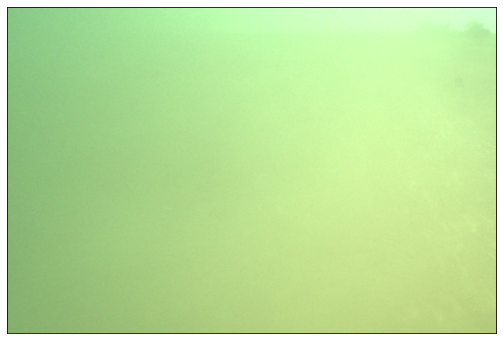

In [105]:
N = 5
save_dir = '/data/jupiter/li.yu/data/spark_events/for_spark_engagements'

# # box in dust
# unique_id = '667c5f5a0df30f8361ef13be_T02_T04'
# sub_dir = os.path.join(save_dir, 'box_in_dust')
# find_sequence_by_image_id(df, unique_id, N, sub_dir)

# half manny in dust
unique_id = '667c621f79de73c09b0e71ab_T02_T04'
sub_dir = os.path.join(save_dir, 'manny_in_dust_1')
find_sequence_by_image_id(df, unique_id, N, sub_dir)

# manny in dust
# unique_id = '66595c9fcc767a29c55c3d0b_T13_T15'  # manny_in_dust_day_1
# unique_id = '66597277916ffe827c688979_T14_T15'  # manny_in_dust_day_2
# unique_id = '6661296208707467156a4bbf_T10_T12'  # manny_in_dust_day_3
# unique_id = '66612753f41de441621eb0f3_T10_T12'  # manny_in_dust_day_4
# unique_id = '6660f32c79c72666e27038fa_T10_T11'  # manny_in_dust_day_5
# unique_id = '66612532d29364b6ba31df45_T10_T12'  # manny_in_dust_day_6
# unique_id = '6659727a5634b1b84bd06488_T13_T15'  # manny_in_dust_day_7
# unique_id = '66596e8efe138e3c73c37121_T14_T15'  # manny_in_dust_day_8
# unique_id = '6660f28279c72666e27036ff_T10_T11'  # manny_in_dust_day_9
# unique_id = '665faee53bf6acdaa7dd1f6d_T02_T03'  # manny_in_dust_night_1
# unique_id = '665fadb4210238339ce7b697_T14_T16'  # manny_in_dust_night_2
# unique_id = '665fc33fb4b8480bd69e179f_T02_T03'  # manny_in_dust_night_3
# unique_id = '665fc06b087074671566030b_T02_T03'  # manny_in_dust_night_4
# unique_id = '665fad13210238339ce7b448_T02_T03'  # manny_in_dust_night_5
# unique_id = '665fc1b8210238339ce7d77e_T13_T15'  # manny_in_dust_night_6
# unique_id = '66a937031e6ba18db4866294_T09_T11'  # manny_in_dust_night_7
# unique_id = '66a9353711b92388a2415e70_T10_T12'  # manny_in_dust_night_8
# unique_id = '66a93bb1e5bfbd5a8bb43c23_T10_T12'  # manny_in_dust_night_9
# unique_id = '665fb073087074671565ba1c_T13_T15'  # manny_in_dust_night_10
# unique_id = '66a93498236d482c28b10285_T09_T11'  # manny_in_dust_night_11
# unique_id = '6660f32c79c72666e27038fa_T10_T12'  # true_negative_day_1
# unique_id = '6660f314f5ffe7d6dbf6a3be_T10_T12'  # true_negative_day_2
# unique_id = '66596ec44cd992b0cf1ba93b_T14_T16'  # true_negative_day_3
# unique_id = '6660f2b3b5b4c40fa023f221_T10_T12'  # true_negative_day_4
# unique_id = '66612579579ccf8da18f5325_T10_T12'  # true_negative_day_5
# unique_id = '6660f32c79c72666e27038fa_T10_T12'  # true_negative_day_6
# unique_id = '665fc281587f8ad113c00a65_T02_T04'  # true_negative_night_1
# unique_id = '665fc07aad6a8b9401888a64_T14_T16'  # true_negative_night_2
# unique_id = '66a937a9d95513a8984bbf63_T02_T04'  # true_negative_night_3
# unique_id = '66a9350e2312cd9d226f5b7a_T02_T04'  # true_negative_night_4
# unique_id = '665fc3270aa0bf26ba6d8053_T02_T04'  # true_negative_night_5
# unique_id = '665fbf8425f8c9f2cbd7875b_T02_T04'  # true_negative_night_6
# sub_dir = os.path.join(save_dir, 'true_negative_night_6')
# find_sequence_by_image_id(df, unique_id, N, sub_dir)